# LightGBM Model with Engineered Features

Train a LightGBM model using engineered features.

**Acceptance Criteria:**
- Model trained successfully
- ROC-AUC improvement over baseline (0.747)
- Hyperparameters documented

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt

## 1. Load Data

In [ ]:
# Load pre-merged features
df = pd.read_csv('../data/processed/final_train_features.csv')
print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {df['TARGET'].value_counts(normalize=True).to_dict()}")

Dataset shape: (307511, 134)
Target distribution: {0: 0.9192711805431351, 1: 0.08072881945686496}


## 2. Preprocessing

In [ ]:
# Separate target
X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df['TARGET']

print(f"Features: {X.shape}")
print(f"Target distribution: {y.value_counts(normalize=True).to_dict()}")

Features: (307511, 132)
Target distribution: {0: 0.9192711805431351, 1: 0.08072881945686496}


In [ ]:
# Identify column types
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

Numeric columns: 120
Categorical columns: 12


In [ ]:
# Convert categorical columns to category dtype (LightGBM handles this natively)
for col in categorical_cols:
    X[col] = X[col].astype('category')

print(f"Converted {len(categorical_cols)} columns to category dtype")

Converted 12 columns to category dtype


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (246008, 132)
Test set: (61503, 132)


## 3. Train LightGBM Model

In [ ]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [ ]:
# Hyperparameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
    'n_jobs': -1,
}

print("Hyperparameters:")
for k, v in params.items():
    print(f"  {k}: {v}")

Hyperparameters:
  objective: binary
  metric: auc
  boosting_type: gbdt
  num_leaves: 31
  learning_rate: 0.05
  feature_fraction: 0.8
  bagging_fraction: 0.8
  bagging_freq: 5
  verbose: -1
  random_state: 42
  n_jobs: -1


In [ ]:
# Train model
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\nBest iteration: {model.best_iteration}")

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.794084	test's auc: 0.770878
[200]	train's auc: 0.820964	test's auc: 0.775723
[300]	train's auc: 0.84334	test's auc: 0.777076
Early stopping, best iteration is:
[328]	train's auc: 0.848689	test's auc: 0.777297

Best iteration: 328


## 4. Evaluate Model

In [ ]:
# Predict probabilities
y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Calculate ROC-AUC
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

# Baseline comparison
baseline_auc = 0.747
improvement = test_auc - baseline_auc

print("="*60)
print("LIGHTGBM MODEL RESULTS")
print("="*60)
print(f"Training ROC-AUC:   {train_auc:.4f}")
print(f"Test ROC-AUC:       {test_auc:.4f}")
print(f"")
print(f"Baseline ROC-AUC:   {baseline_auc:.4f}")
print(f"Improvement:        {improvement:+.4f} ({improvement/baseline_auc*100:+.2f}%)")
print("="*60)

LIGHTGBM MODEL RESULTS
Training ROC-AUC:   0.8487
Test ROC-AUC:       0.7773

Baseline ROC-AUC:   0.7470
Improvement:        +0.0303 (+4.06%)


In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

Top 20 Most Important Features:
                      feature   importance
                 EXT_SOURCE_2 44683.719468
                 EXT_SOURCE_3 41559.032502
            ORGANIZATION_TYPE 20029.275209
            LATE_PAYMENT_RATE  7418.784991
     BUREAU_DEBT_CREDIT_RATIO  6755.955269
                   DAYS_BIRTH  6725.165473
                   TOTAL_PAID  6676.753331
               CC_AVG_BALANCE  6023.127851
                   AMT_CREDIT  5736.820171
                  AMT_ANNUITY  4903.405346
PREV_CREDIT_APPLICATION_RATIO  4812.653903
        PREV_CNT_PAYMENT_MEAN  4753.926518
                  CODE_GENDER  4594.030032
           PREV_REFUSED_RATIO  4577.468562
       BUREAU_DAYS_CREDIT_MAX  4565.546404
      BUREAU_DAYS_CREDIT_MEAN  4562.708952
                DAYS_EMPLOYED  4440.273008
              AMT_GOODS_PRICE  4376.419770
          NAME_EDUCATION_TYPE  3983.446401
        PREV_DOWN_PAYMENT_MAX  3605.356586


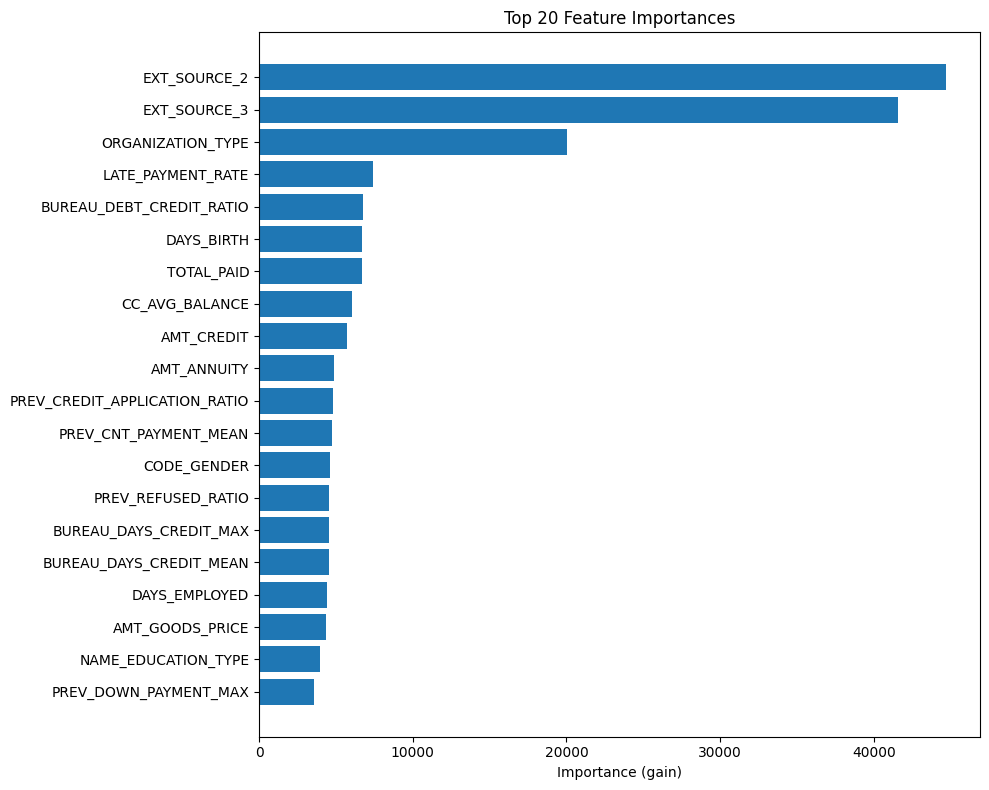

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'].head(20)[::-1], 
         feature_importance['importance'].head(20)[::-1])
plt.xlabel('Importance (gain)')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

## 5. Model Documentation

### Hyperparameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| objective | binary | Binary classification |
| metric | auc | Optimize for ROC-AUC |
| boosting_type | gbdt | Gradient Boosting Decision Tree |
| num_leaves | 31 | Max leaves per tree |
| learning_rate | 0.05 | Step size shrinkage |
| feature_fraction | 0.8 | Subsample ratio of features |
| bagging_fraction | 0.8 | Subsample ratio of data |
| bagging_freq | 5 | Frequency for bagging |
| early_stopping_rounds | 50 | Stop if no improvement |

### Results Summary

| Metric | Baseline (LogReg) | LightGBM | Improvement |
|--------|-------------------|----------|-------------|
| Test ROC-AUC | 0.747 | TBD | TBD |

### Features Used
- Application features (main table)
- Bureau features (credit history)
- Previous application features (past loans)
- Payment balance features (repayment behavior)

In [ ]:
# Final summary
results = {
    'model': 'LightGBM',
    'train_auc': train_auc,
    'test_auc': test_auc,
    'baseline_auc': baseline_auc,
    'improvement': improvement,
    'n_features': X.shape[1],
    'best_iteration': model.best_iteration,
    'hyperparameters': params
}

print("\nFinal Results Summary:")
for key, value in results.items():
    if key != 'hyperparameters':
        print(f"  {key}: {value}")


Final Results Summary:
  model: LightGBM
  train_auc: 0.8486889882786881
  test_auc: 0.7772974548893085
  baseline_auc: 0.747
  improvement: 0.03029745488930846
  n_features: 132
  best_iteration: 328


Now our SHAP notebook will also be able to load the model:

In [ ]:
import joblib

save_path = '../models/lightgbm_model.pkl'
joblib.dump(model, save_path)

print(f"Model saved to: {save_path}")
